In [1]:
%load_ext autoreload
%autoreload 2
%env WANDB_NOTEBOOK_NAME exploration.ipynb
%env WANDB_SILENT true

env: WANDB_NOTEBOOK_NAME=exploration.ipynb
env: WANDB_SILENT=true


In [2]:
from collections import defaultdict
import itertools
import os

import inept
from IPython import display
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import wandb

# Set params
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_FOLDER = os.path.join(os.path.abspath(''), '../data')
PLOT_FOLDER = os.path.join(os.path.abspath(''), '../plots')
TEMP_FOLDER = os.path.join(os.path.abspath(''), 'temp')

# Disable gradients
torch.set_grad_enabled(False)

# Style
sns.set_theme(context='paper', style='white', palette='Set2')

### Load Files

In [3]:
# Load run from the wandb API
api = wandb.Api()
run = api.run('oafish/INEPT/t0vuvlm2')

# Load configs
config = defaultdict(lambda: {})
for k, v in run.config.items():
    dict_name, key = k.split('/')
    config[dict_name][key] = v
config = dict(config)

# Load model
run.file('trained_models/policy.mdl').download(TEMP_FOLDER, replace=True)
policy = torch.load(os.path.join(TEMP_FOLDER, 'trained_models/policy.mdl')).to(DEVICE)
policy.actor.set_action_std(1e-7)  # Place in execution mode

In [4]:
# MMD-MA data
M1 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_mapped1.txt'), delimiter='\t', header=None).to_numpy()
M2 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_mapped2.txt'), delimiter='\t', header=None).to_numpy()
T1 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_type1.txt'), delimiter='\t', header=None).to_numpy()
T2 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_type2.txt'), delimiter='\t', header=None).to_numpy()

In [5]:
# Reproducibility
torch.manual_seed(config['note']['seed'])
if DEVICE == 'cuda': torch.cuda.manual_seed(config['note']['seed'])
np.random.seed(config['note']['seed'])

# Load config
num_nodes = config['data']['num_nodes']
generalize = True

if config['data']['dataset'] == 'MMD-MA':
    # MMD-MA data
    M1 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_mapped1.txt'), delimiter='\t', header=None).to_numpy()
    M2 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_mapped2.txt'), delimiter='\t', header=None).to_numpy()
    T1 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_type1.txt'), delimiter='\t', header=None).to_numpy()
    T2 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_type2.txt'), delimiter='\t', header=None).to_numpy()
    # Params
    if generalize: num_nodes = M1.shape[0]
    # Subsample
    np.random.seed(config['note']['seed'])
    idx = np.random.choice(M1.shape[0], num_nodes, replace=False)
    idx_1 = np.random.choice(M1.shape[1], 16, replace=False)
    idx_2 = np.random.choice(M2.shape[1], 16, replace=False)
    M1 = torch.tensor(M1[idx][:, idx_1], dtype=torch.float32, device=DEVICE)
    M2 = torch.tensor(M2[idx][:, idx_2], dtype=torch.float32, device=DEVICE)
    T1 = torch.tensor(T1[idx], dtype=torch.long, device=DEVICE)
    T2 = torch.tensor(T2[idx], dtype=torch.long, device=DEVICE)
    modalities = (M1, M2)

elif config['data']['dataset'] == 'Random':
    # Random data
    torch.manual_seed(config['note']['seed'])
    M1 = torch.rand((num_nodes, 8), device=DEVICE)
    M2 = torch.rand((num_nodes, 16), device=DEVICE)
    T1 = torch.zeros(num_nodes, dtype=torch.long, device=DEVICE)
    modalities = (M1, M2)

else: assert False, 'No matching dataset found.'

# Environment
# config['env']['reward_distance_type'] = config['env'].pop('reward_type')
env = inept.environments.trajectory(*modalities, **config['env'], device=DEVICE)

### Plot Performance

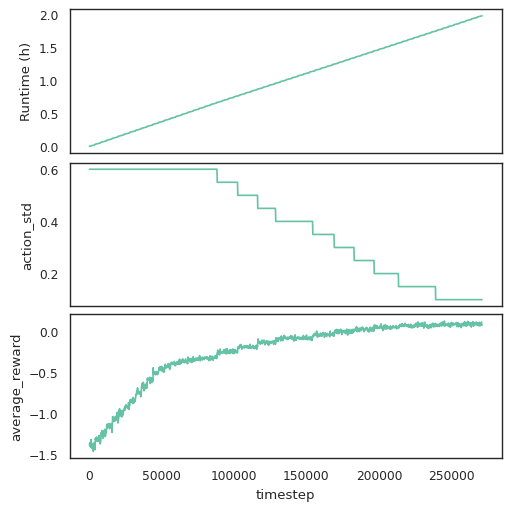

In [6]:
# Load history from wandb
history = run.history(samples=2000)
history['timestep'] = history['end_timestep']
history['Runtime (h)'] = history['_runtime'] / 60**2

# Plot
fig, axs = plt.subplots(3, 1, figsize=(5, 5), sharex=True, layout='constrained')
axs = axs.flatten()
sns.lineplot(history, x='timestep', y='Runtime (h)', ax=axs[0])
sns.lineplot(history, x='timestep', y='action_std', ax=axs[1])
sns.lineplot(history, x='timestep', y='average_reward', ax=axs[2])
plt.show()

### Animate Latent Space

In [7]:
%matplotlib agg

# Animation parameters
timescale = 10  # Factor speedup
skip = 3  # Only show frames (frame % skip) == 0
center = False
save_to_file = True
file_type = 'mp4'  # gif for export, mp4 for preview

# Calculated parameters
frames = int(config['train']['max_ep_timesteps'] / skip)
interval = int(1e3 * env.delta * skip / timescale)
fps = int(1e3 / interval)  # fps should be ~30 for gif

# Create figure and reset environment
fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
env.reset()
pos = env.get_state().cpu()[:, :2]
if center: pos = pos - pos.mean(dim=0)  # Center for visualization
sct = ax.scatter(*pos.T, c=T1.cpu().flatten())

# Formatting
ax.set_aspect('equal')
ax.set_xlim([-env.pos_bound-.2, env.pos_bound+.2])
ax.set_ylim([-env.pos_bound-.2, env.pos_bound+.2])

# Update function
def update(frame):
    # Escape if finished
    if env.finished(): ax.set_title(f'Finished'); return

    # Step environment
    for _ in range(skip):
        with torch.no_grad():
            state = env.get_state(include_modalities=True)
            self_entity = state
            idx = torch.zeros((num_nodes, num_nodes), dtype=torch.bool)
            for i, j in itertools.product(*[range(x) for x in idx.shape]):
                idx[i, j] = i!=j
            node_entities = state.unsqueeze(0).expand(num_nodes, *state.shape)
            node_entities = node_entities[idx].reshape(num_nodes, num_nodes-1, run.config['policy/num_features_per_node'])
            rewards, finished = env.step(policy.act(self_entity, node_entities).detach())
        if finished: break

    # Draw
    pos = env.get_state().cpu()[:, :2]
    if center: pos = pos - pos.mean(dim=0)  # Center for visualization
    sct.set_offsets(pos)
    ax.set_title(f'Reward: {rewards.cpu().mean().item(): 0.4f}')
    return sct

# Run animation
ani = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=interval)
if file_type == 'mp4':
    writer = animation.FFMpegWriter(fps=fps, metadata={'artist': 'INEPT'}, extra_args=['-vcodec', 'libx264'], bitrate=8e3)
    fname = config['data']['dataset']
elif file_type == 'gif':
    writer = animation.FFMpegWriter(fps=fps)
    fname = 'sample'
if save_to_file: ani.save(os.path.join(PLOT_FOLDER, f'{fname}.{file_type}'), writer=writer)  # Save
else: display(ani.to_jshtml())  # Display

# Will be near zero if centered
print(f'{env.pos.mean(dim=0).square().sum().cpu().item():.3f}')

0.407
